##milopy basic installation and tutorial##

In [1]:
import scanpy as sc
import numpy as np

import milopy
import milopy.core as milo

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

#adata = sc.read_h5ad("/Users/Ali/Desktop/Mehtonen et al./GSE148218_RAW/adata_rb.h5ad")
#adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


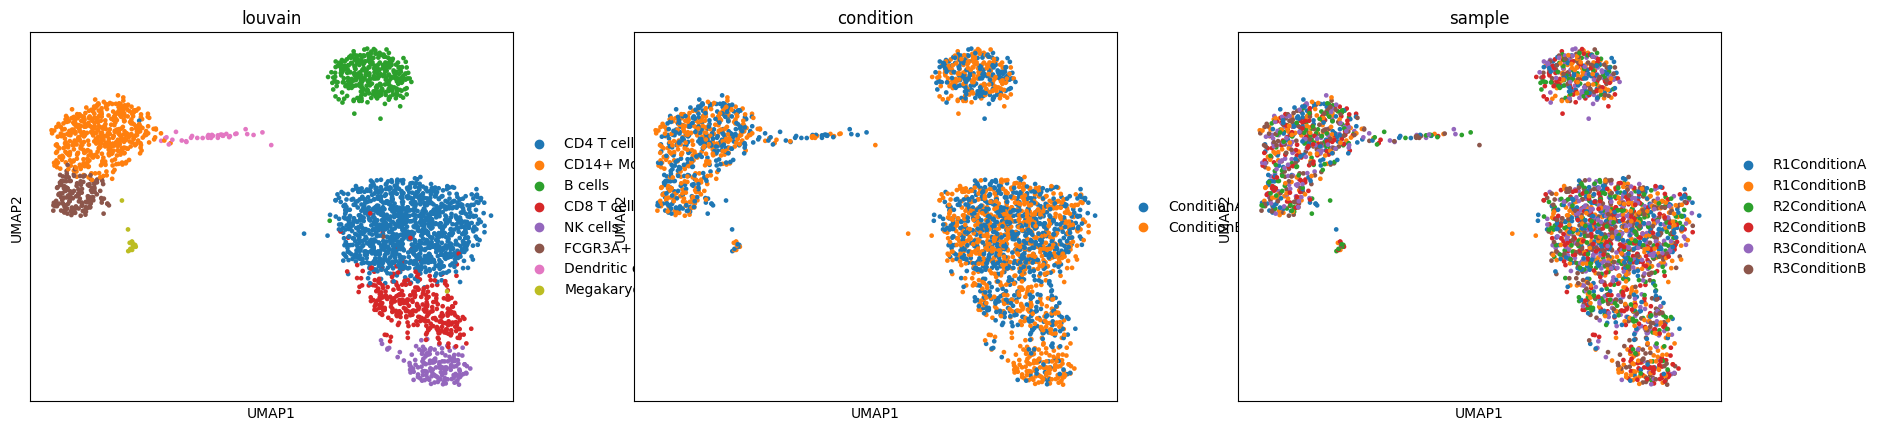

In [3]:
## Simulate experimental condition ##
adata.obs["condition"] = np.random.choice(["ConditionA", "ConditionB"], size=adata.n_obs, p=[0.5,0.5])
# we simulate differential abundance in NK cells
DA_cells = adata.obs["louvain"] == "NK cells"
adata.obs.loc[DA_cells, "condition"] = np.random.choice(["ConditionA", "ConditionB"], size=sum(DA_cells), p=[0.2,0.8])

## Simulate replicates ##
adata.obs["replicate"] = np.random.choice(["R1", "R2", "R3"], size=adata.n_obs)
adata.obs["sample"] = adata.obs["replicate"] + adata.obs["condition"]

sc.pl.umap(adata, color=["louvain","condition", "sample"])

In [4]:
## Build KNN graph
sc.pp.neighbors(adata, n_neighbors=10)

## Assign cells to neighbourhoods
milo.make_nhoods(adata)

## Count cells from each sample in each nhood
milo.count_nhoods(adata, sample_col="sample")

## Test for differential abundance between conditions
milo.DA_nhoods(adata, design="~ condition")

## Check results
milo_results = adata.uns["nhood_adata"].obs
milo_results

/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/umap/d

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,AAAGAGACGGACTT-1,8.797401,-0.483135,13.478371,1.532426,0.216359,0.893743,0.971161
1,AAATCCCTCCACAA-1,9.078802,0.196178,12.845126,0.187953,0.673615,0.971161,0.971161
2,AAATTGACTCGCTC-1,8.916060,-0.091824,13.161161,0.047282,0.827955,0.971161,0.971161
3,AACTGTCTCCCTTG-1,9.932610,0.397096,12.722278,0.726203,0.421449,0.971161,0.971161
4,AAGATTACTCCTCG-1,8.917719,-0.034087,14.011775,0.017754,0.906305,0.971161,0.971161
...,...,...,...,...,...,...,...,...
114,TTAGCTACAACCGT-1,8.916946,-0.119043,12.722281,0.066003,0.808480,0.971161,0.971161
115,TTCAAAGATAAAGG-1,10.230790,0.133663,13.207688,0.102445,0.749056,0.971161,0.971161
116,TTCAGACTACCCAA-1,8.558914,-0.934460,12.587971,3.386534,0.080347,0.682947,0.833316
117,TTCATGTGTGGTGT-1,8.169439,-0.376089,13.815385,1.571438,0.229659,0.893743,0.971161


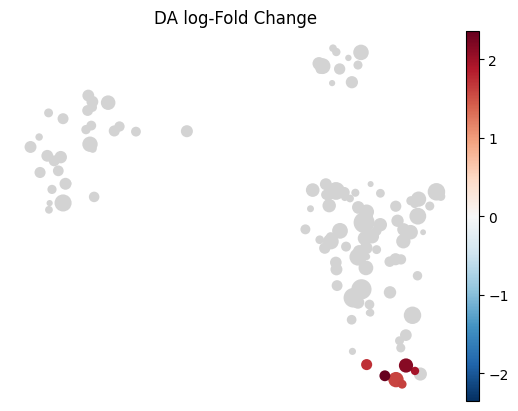

In [5]:
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha=0.2, min_size=5)

In [7]:
# milopy.utils.annotate_nhoods(adata, anno_col='louvain')


Differential abundance analysis in python with milopy

In [6]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo  ## For mouse gastrulation data 
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

import milopy.core as milo
import milopy.plot as milopl

In [ ]:
adata = scvelo.datasets.gastrulation()

In [ ]:
adata

AnnData object with n_obs × n_vars = 89267 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

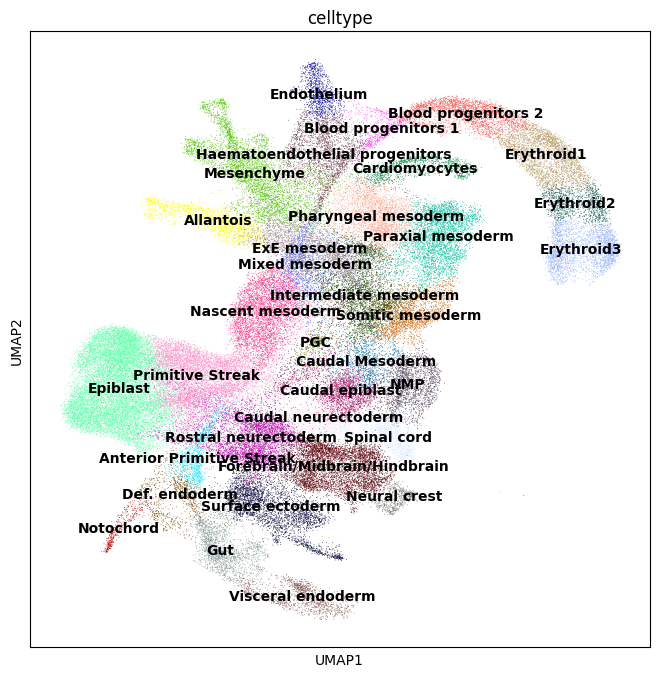

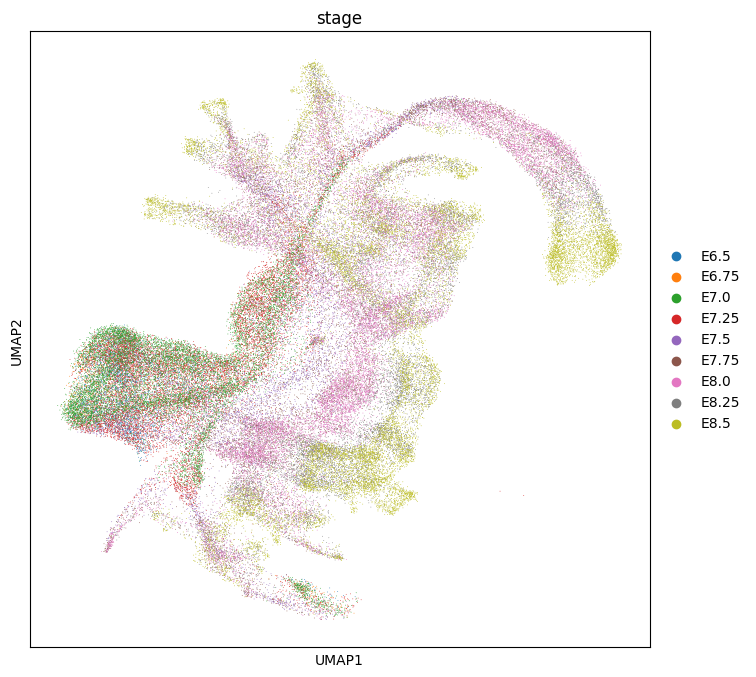

In [ ]:
sc.pl.umap(adata, color=["celltype"], legend_loc="on data");
sc.pl.umap(adata, color=["stage"]);

In [ ]:
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:19)


In [ ]:
milo.make_nhoods(adata, prop=0.1)

In [ ]:
adata.obsm["nhoods"]

<89267x4558 sparse matrix of type '<class 'numpy.float32'>'
	with 593853 stored elements in Compressed Sparse Row format>

In [ ]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
index,,
cell_230,1,3.921264
cell_268,1,4.179702
cell_401,1,4.293635
cell_403,1,5.405342
cell_617,1,7.682445
...,...,...
cell_139055,1,6.774024
cell_139159,1,5.092332
cell_139206,1,5.132385


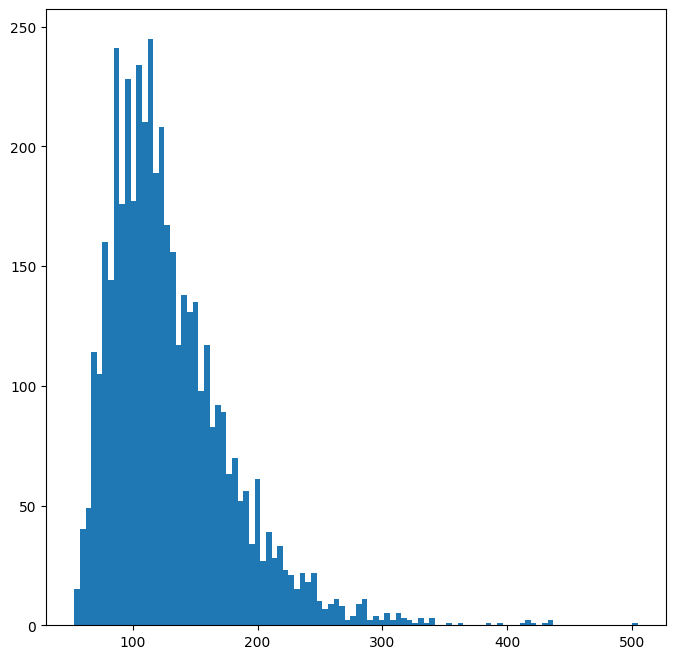

In [ ]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);


In [ ]:
milo.count_nhoods(adata, sample_col="sample")
adata.uns["nhood_adata"]
adata.obs["stage_continuous"] = adata.obs["stage"].cat.codes
milo.DA_nhoods(adata, design="~stage_continuous")

In [ ]:
adata.uns["nhood_adata"].obs


,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,cell_230,3.921264,-1.467154,8.714289,185.755432,1.320111e-16,7.078898e-15,7.678910e-15
1,cell_268,4.179702,-1.312406,8.524773,105.878390,2.799268e-13,1.487070e-12,1.551825e-12
2,cell_401,4.293635,0.145622,8.674295,0.125138,7.252239e-01,7.395012e-01,7.380886e-01
3,cell_403,5.405342,0.456820,8.330220,3.996096,5.181581e-02,5.680050e-02,5.626586e-02
4,cell_617,7.682445,0.539216,8.564910,6.178718,1.680721e-02,1.894812e-02,1.873437e-02
...,...,...,...,...,...,...,...,...
4553,cell_139055,6.774024,1.319331,8.787448,119.103477,4.297817e-14,2.941359e-13,3.077740e-13
4554,cell_139159,5.092332,1.390857,8.398578,128.972395,9.090921e-14,5.569411e-13,5.821416e-13
4555,cell_139206,5.132385,1.264800,8.544171,97.490171,1.004185e-12,4.604703e-12,4.816163e-12
4556,cell_139212,3.474515,1.715458,9.212690,226.960138,1.949244e-10,6.056341e-10,6.303509e-10


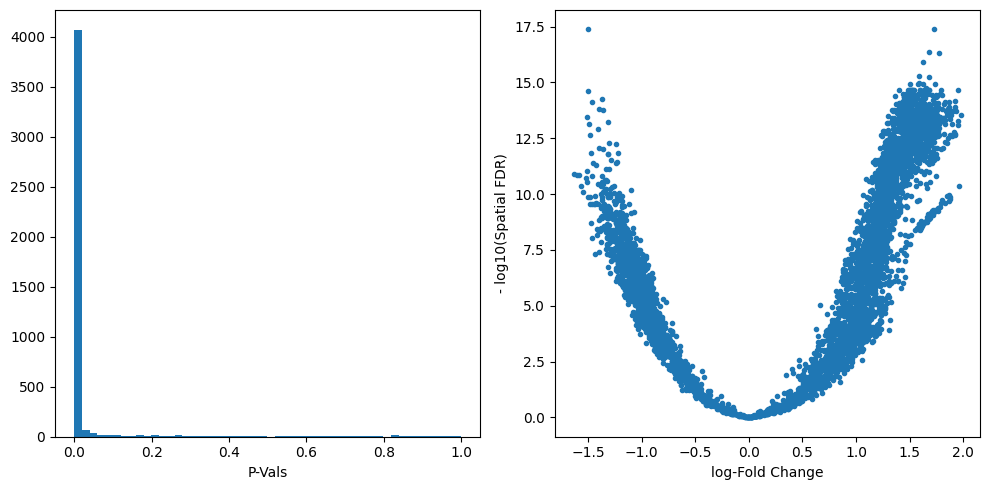

In [ ]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize


In [ ]:
import milopy.utils
milopy.utils.build_nhood_graph(adata)

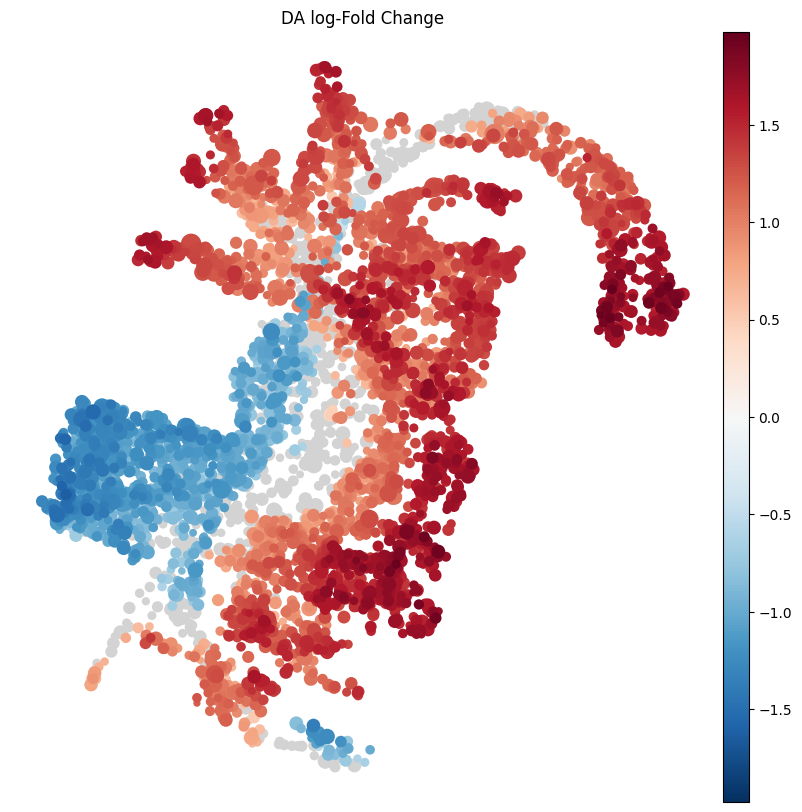

In [ ]:
plt.rcParams["figure.figsize"] = [10,10]
milopl.plot_nhood_graph(adata, 
                        alpha=0.01, ## SpatialFDR level (1%) 
                        min_size=2 ## Size of smallest dot
                       )

In [ ]:
adata.uns["nhood_adata"].obs


,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR,Nhood_size
0,cell_230,3.921264,-1.467154,8.714289,185.755432,1.320111e-16,7.078898e-15,7.678910e-15,75.0
1,cell_268,4.179702,-1.312406,8.524773,105.878390,2.799268e-13,1.487070e-12,1.551825e-12,65.0
2,cell_401,4.293635,0.145622,8.674295,0.125138,7.252239e-01,7.395012e-01,7.380886e-01,97.0
3,cell_403,5.405342,0.456820,8.330220,3.996096,5.181581e-02,5.680050e-02,5.626586e-02,84.0
4,cell_617,7.682445,0.539216,8.564910,6.178718,1.680721e-02,1.894812e-02,1.873437e-02,97.0
...,...,...,...,...,...,...,...,...,...
4553,cell_139055,6.774024,1.319331,8.787448,119.103477,4.297817e-14,2.941359e-13,3.077740e-13,94.0
4554,cell_139159,5.092332,1.390857,8.398578,128.972395,9.090921e-14,5.569411e-13,5.821416e-13,63.0
4555,cell_139206,5.132385,1.264800,8.544171,97.490171,1.004185e-12,4.604703e-12,4.816163e-12,89.0
4556,cell_139212,3.474515,1.715458,9.212690,226.960138,1.949244e-10,6.056341e-10,6.303509e-10,113.0


In [ ]:
import scipy
anno_dummies = pd.get_dummies(adata.obs['celltype'])
anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
anno_frac = np.array(scipy.sparse.csr_matrix(anno_count/anno_count.sum(1)))
anno_frac

array(<4558x34 sparse matrix of type '<class 'numpy.float32'>'
	with 10177 stored elements in Compressed Sparse Row format>, dtype=object)

In [ ]:
anno_frac.shape

(4558, 34)

In [ ]:
adata.uns["nhood_adata"].obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '4548', '4549', '4550', '4551', '4552', '4553', '4554', '4555', '4556',
       '4557'],
      dtype='object', length=4558)

In [ ]:
anno_dummies.columns

CategoricalIndex(['Allantois', 'Anterior Primitive Streak',
                  'Blood progenitors 1', 'Blood progenitors 2',
                  'Cardiomyocytes', 'Caudal Mesoderm', 'Caudal epiblast',
                  'Caudal neurectoderm', 'Def. endoderm', 'Endothelium',
                  'Epiblast', 'Erythroid1', 'Erythroid2', 'Erythroid3',
                  'ExE mesoderm', 'Forebrain/Midbrain/Hindbrain', 'Gut',
                  'Haematoendothelial progenitors', 'Intermediate mesoderm',
                  'Mesenchyme', 'Mixed mesoderm', 'NMP', 'Nascent mesoderm',
                  'Neural crest', 'Notochord', 'PGC', 'Paraxial mesoderm',
                  'Pharyngeal mesoderm', 'Primitive Streak',
                  'Rostral neurectoderm', 'Somitic mesoderm', 'Spinal cord',
                  'Surface ectoderm', 'Visceral endoderm'],
                 categories=['Allantois', 'Anterior Primitive Streak', 'Blood progenitors 1', 'Blood progenitors 2', ..., 'Somitic mesoderm', 'Spinal cord', 

In [ ]:
anno_frac = pd.DataFrame(anno_frac,
                          columns=anno_dummies.columns,
                          index=adata.uns["nhood_adata"].obs_names
)

ValueError: Must pass 2-d input. shape=()

In [ ]:
anno_frac

,0
0,"(0, 10)\t0.9866667\n (0, 28)\t0.013333334"
1,"(0, 10)\t1.0"
2,"(0, 6)\t0.030927833\n (0, 28)\t0.020618556\..."
3,"(0, 19)\t1.0"
4,"(0, 16)\t0.21649484\n (0, 33)\t0.78350514"
...,...
4553,"(0, 16)\t0.98936164\n (0, 32)\t0.010638298"
4554,"(0, 5)\t0.015873017\n (0, 21)\t0.98412704"
4555,"(0, 18)\t0.123595506\n (0, 27)\t0.8764045"
4556,"(0, 13)\t1.0"


In [ ]:
# from scipy.sparse import csr_matrix

In [ ]:
# csr_matrix(anno_frac)

In [ ]:
# adata.obs['stage_continuous']= adata.obs['stage_continuous'].astype("category")
milopy.utils.annotate_nhoods(adata, anno_col='celltype')


ValueError: Shape of passed values is (4558, 1), indices imply (4558, 34)

In [ ]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")


KeyError: 'nhood_annotation_frac'

In [ ]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"


In [ ]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()